In [70]:
import boto3
import dask
from dask.distributed import Client, LocalCluster, progress

from datetime import datetime
import fsspec
from glob import glob
from http.cookiejar import CookieJar
import json
import logging
import matplotlib.pyplot as plt
from netrc import netrc
import numpy as np
import os
from os.path import basename, isfile, isdir, join, expanduser
import pandas as pd
import pathlib
from pathlib import Path
from platform import system
from pprint import pprint
import shutil
import subprocess
import requests
import s3fs
import time as time
from tqdm import tqdm
import ujson
from urllib import request
import warnings
import xarray as xr

# not needed if processing files on my own s3
#https://pypi.org/project/python-cmr/
from cmr import CollectionQuery, GranuleQuery, ToolQuery, ServiceQuery, VariableQuery

warnings.filterwarnings("ignore")

# Dask often throws probably harmless warnings when the client/cluster leave
# the context manager about "stream closed" connectionPool heartbeat_worker etc.
# Silencing the warning with the following as per:
# https://github.com/dask/distributed/issues/7105
warnings.simplefilter("ignore", dask.distributed.comm.core.CommClosedError)

In [3]:
# Dask often throws probably harmless warnings when the client/cluster leave
# the context manager about "stream closed" connectionPool heartbeat_worker etc.
# Silencing the warning with the following as per:
# https://github.com/dask/distributed/issues/7105
warnings.simplefilter("ignore", dask.distributed.comm.core.CommClosedError)

dtmp =  Path('/tmp/dask-scratch-space');

if dtmp.exists():
    try:
        shutil.rmtree(dtmp)
    except: 
        print('could not delete dask scratch space')
else:
    print(f'{dtmp} does not exist')

# from the following:
# https://dask.discourse.group/t/dask-workers-killed-because-of-heartbeat-fail/856
from dask import config as cfg 
cfg.set({'distributed.scheduler.worker-ttl': None})
cfg.set({'heartbeat': '90s', 'scheduler-info-interval': '90s'})
cfg.set(temporary_directory=str('/tmp'))

/tmp/dask-scratch-space does not exist


In [9]:
def get_credentials(use_earthdata=False):

    if use_earthdata == False:
        # If the netcdf files are on a bucket you control and you are on an ec2
        
        session = boto3.Session()
        credentials_b3 = session.get_credentials()
        creds_b3 = credentials_b3.get_frozen_credentials()
        
        credentials = dict()
        credentials['secretAccessKey'] = credentials_b3.secret_key
        credentials['accessKeyId'] = credentials_b3.access_key
        credentials['sessionToken'] = credentials_b3.token

    else:
        
        # if the netcdf files are on po cloud
        credentials = requests.get('https://archive.podaac.earthdata.nasa.gov/s3credentials').json()
        
    return credentials
    

In [38]:
def update_credential(s3, credentials, use_earthdata, 
                      requester_pays=False, force=False):
    
    if 'expiration' not in credentials.keys():
        print('... credentials do not expire, no need to update')
        return
    
    
    now=np.datetime64(datetime.now())
    
    # expiration time of current credential
    exp=np.datetime64(credentials['expiration'][:-6])
    # current time
    
    # how much time is left [seconds]
    td_sec = np.double(exp-now)/1e6

    # if < 1800 seconds left before credential expires, renew it
    if (td_sec < 1800) or (force==True):
        print(f'... updating credentials, {td_sec}s remaining')
        
        s3_tmp, credentials_tmp= init_S3FileSystem(use_earthdata, requester_pays=requester_pays)

        exp=np.datetime64(credentials_tmp['expiration'][:-6])
        td_sec = np.double(exp-now)/1e6
        
        print(f'... after credential update, {td_sec}s remaining')

        # update s3 and credential objects in place 
        s3 = s3_tmp
        credentials = credentials_tmp
        
    else:
        print(f'... not updating credentials, {td_sec}s remaining')

    return 

In [71]:
def init_S3FileSystem(use_earthdata=False, requester_pays=False):
    """
    This routine creates a credentials dictionary and an s3fs objects.
    
    if use_earthdata == True:
        pulls your EDL crediential from .netrc file and obtains an AWS S3 credential 
        through a PO.DAAC service accessible at https://archive.podaac.earthdata.nasa.gov/s3credentials.
        From the PO.DAAC Github (https://podaac.github.io/tutorials/external/July_2022_Earthdata_Webinar.html).
    
    else if use_earthdata = False:
        creates an generic credential with the setting 'requester_pays'.
            
    Returns:
    =======
    
    s3: an AWS S3 filesystem
    credentials: a dictionary
    
    """
  
    credentials = get_credentials(use_earthdata=use_earthdata)
    
    s3 = s3fs.S3FileSystem(requester_pays=requester_pays,
                           anon=False,
                           key=credentials['accessKeyId'],
                           secret=credentials['secretAccessKey'], 
                           token=credentials['sessionToken'])
    
    return s3, credentials

## Set up S3FS and Credentials for EarthData and 'public' ECCO S3 bucket

In [105]:
# create the credentials and s3fs object for PO.CLOUD
s3_pocloud, credentials_pocloud = init_S3FileSystem(use_earthdata=True)

# create the credentials and s3fs object for ECCO's public bucket, s3://ecco-model-granules
# ... needs requester_pays = True
s3_ecco_model_granules, credentials_ecco_model_granules = init_S3FileSystem(use_earthdata=False,
                                                                            requester_pays=True)

In [74]:
# test the credential updating
print('attempting to update earthdata credential')
update_credential(s3_pocloud, credentials_pocloud, use_earthdata=True, 
                  requester_pays=False, force=True)

print('\nattempting to update the ecco model granule credential')
update_credential(s3_ecco_model_granules, credentials_ecco_model_granules, 
                  use_earthdata=True, requester_pays=False, force=True)


attempting to update earthdata credential
... updating credentials, 3591.557512s remaining
... after credential update, 3600.557512s remaining

attempting to update the ecco model granule credential
... credentials do not expire, no need to update


# load ECCO V4r4 MZZ json files

In [78]:
def list_s3_folders(s3_path, s3_fs):
    # Ensure path ends with slash to look *under* the prefix
    if not s3_path.endswith('/'):
        s3_path += '/'

    # List objects with detail=True to get type info
    items = s3_fs.ls(s3_path, detail=True)

    # Filter for directories only
    folders = [item['name'] for item in items if item['type'] == 'directory']
    return folders

In [94]:
def list_s3_files(s3_path, s3_fs):
    # Ensure path ends with slash to look *under* the prefix
    if not s3_path.endswith('/'):
        s3_path += '/'

    # List objects with detail=True to get type info
    items = s3_fs.ls(s3_path, detail=True)

    # Filter for directories only
    files = [item['name'] for item in items if item['type'] == 'file']
    return files

### Show top-level categories of MZZ files 

Note subdirectory names indicate:
```
1. grid type (05DEG vs. LLC0090)
2. temporal frequency  (DAILY vs. MONTHLY vs. SNAPSHOT)
3. some time-invariant fields: GEOMETRY, MIXING COEFFICIENTS
```

In [77]:
MZZ_dir = 's3://ecco-model-granules/V4r4/mzz_jsons/'

In [95]:
list_s3_folders(MZZ_dir, s3_ecco_model_granules)

['ecco-model-granules/V4r4/mzz_jsons/MZZ_05DEG_DAILY',
 'ecco-model-granules/V4r4/mzz_jsons/MZZ_05DEG_GEOMETRY',
 'ecco-model-granules/V4r4/mzz_jsons/MZZ_05DEG_MIXING_COEFFS',
 'ecco-model-granules/V4r4/mzz_jsons/MZZ_05DEG_MONTHLY',
 'ecco-model-granules/V4r4/mzz_jsons/MZZ_LLC0090GRID_DAILY',
 'ecco-model-granules/V4r4/mzz_jsons/MZZ_LLC0090GRID_GEOMETRY',
 'ecco-model-granules/V4r4/mzz_jsons/MZZ_LLC0090GRID_MIXING_COEFFS',
 'ecco-model-granules/V4r4/mzz_jsons/MZZ_LLC0090GRID_MONTHLY',
 'ecco-model-granules/V4r4/mzz_jsons/MZZ_LLC0090GRID_SNAPSHOT']

### Show datasets of llc90 grid, monthly mean (kerchunk json files)

In [96]:
MZZ_llc90_monthly_dir = 's3://ecco-model-granules/V4r4/mzz_jsons/MZZ_LLC0090GRID_MONTHLY'
list_s3_files(MZZ_llc90_monthly_dir, s3_ecco_model_granules)

['ecco-model-granules/V4r4/mzz_jsons/MZZ_LLC0090GRID_MONTHLY/ECCO_L4_ATM_STATE_LLC0090GRID_MONTHLY_V4R4.json',
 'ecco-model-granules/V4r4/mzz_jsons/MZZ_LLC0090GRID_MONTHLY/ECCO_L4_BOLUS_LLC0090GRID_MONTHLY_V4R4.json',
 'ecco-model-granules/V4r4/mzz_jsons/MZZ_LLC0090GRID_MONTHLY/ECCO_L4_DENS_STRAT_PRESS_LLC0090GRID_MONTHLY_V4R4.json',
 'ecco-model-granules/V4r4/mzz_jsons/MZZ_LLC0090GRID_MONTHLY/ECCO_L4_FRESH_FLUX_LLC0090GRID_MONTHLY_V4R4.json',
 'ecco-model-granules/V4r4/mzz_jsons/MZZ_LLC0090GRID_MONTHLY/ECCO_L4_HEAT_FLUX_LLC0090GRID_MONTHLY_V4R4.json',
 'ecco-model-granules/V4r4/mzz_jsons/MZZ_LLC0090GRID_MONTHLY/ECCO_L4_MIXED_LAYER_DEPTH_LLC0090GRID_MONTHLY_V4R4.json',
 'ecco-model-granules/V4r4/mzz_jsons/MZZ_LLC0090GRID_MONTHLY/ECCO_L4_OBP_LLC0090GRID_MONTHLY_V4R4.json',
 'ecco-model-granules/V4r4/mzz_jsons/MZZ_LLC0090GRID_MONTHLY/ECCO_L4_OCEAN_3D_MOMENTUM_TEND_LLC0090GRID_MONTHLY_V4R4.json',
 'ecco-model-granules/V4r4/mzz_jsons/MZZ_LLC0090GRID_MONTHLY/ECCO_L4_OCEAN_3D_SALINITY_FLUX_L

## load an example json kerchunk

In [97]:
# Path to your JSON file in S3
json_file_path = 's3://ecco-model-granules/V4r4/mzz_jsons/MZZ_05DEG_MONTHLY/ECCO_L4_SSH_05DEG_MONTHLY_V4R4.json'

# Make sure we can open and read JSON file directly
with s3_ecco_model_granules.open(json_file_path, 'r') as f:
    data = json.load(f)

# Now `data` contains the parsed JSON. 
print(data.keys())

dict_keys(['version', 'refs'])


In [108]:
# loads a dataset from the 'kerchunk' json where the
# netcdf files are stored on one s3 bucket 
# and the kerchunk json file is stored in possibly a different s3 bucket
def load_dataset_from_json_s3(json_file_path, credentials_for_netcdfs, s3fs_for_jsons=None):

    # Check if the JSON file is on S3
    if json_file_path.startswith("s3://"):
        if s3fs_for_jsons is None:
            raise ValueError("s3fs_for_jsons must be provided for remote JSON paths")

        # Read and parse the remote JSON into a dictionary
        with s3fs_for_jsons.open(json_file_path, 'r') as json_file:
            reference_dict = json.load(json_file)
    else:
        # Read and parse the local JSON
        with open(json_file_path, 'r') as json_file:
            reference_dict = json.load(json_file)

    # Create the reference filesystem from the parsed JSON dictionary
    fs = fsspec.filesystem(
        "reference",
        fo=reference_dict,
        remote_protocol="s3",
        remote_options={
            'anon': False,
            'key': credentials_for_netcdfs['accessKeyId'],
            'secret': credentials_for_netcdfs['secretAccessKey'],
            'token': credentials_for_netcdfs['sessionToken']
        },
        skip_instance_cache=True
    )

    # Open the zarr-mapped dataset
    m = fs.get_mapper("")
    ds = xr.open_dataset(m, engine='zarr', consolidated=False, chunks={'time': 20})
    return ds

In [110]:
xx=load_dataset_from_json_s3(json_file_path, 
                             credentials_for_netcdfs=credentials_pocloud,
                             s3fs_for_jsons = s3_ecco_model_granules)


<xarray.Dataset> Size: 970MB
Dimensions:         (time: 312, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * latitude        (latitude) float32 1kB -89.75 -89.25 -88.75 ... 89.25 89.75
    latitude_bnds   (latitude, nv) float32 3kB dask.array<chunksize=(360, 2), meta=np.ndarray>
  * longitude       (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
    longitude_bnds  (longitude, nv) float32 6kB dask.array<chunksize=(720, 2), meta=np.ndarray>
  * time            (time) datetime64[ns] 2kB 1992-01-16T18:00:00 ... 2017-12...
    time_bnds       (time, nv) datetime64[ns] 5kB dask.array<chunksize=(20, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    SSH             (time, latitude, longitude) float32 323MB dask.array<chunksize=(20, 360, 720), meta=np.ndarray>
    SSHIBC          (time, latitude, longitude) float32 323MB dask.array<chunksize=(20, 360, 720), meta=np.ndarray>
    SSHNOIBC        (time, latitude, longitude) float32 323MB dask.array<chunksize=(20, 360, 720), meta=np.ndarray>
Attributes: (12/57)
    Conventions:                  CF-1.8, ACDD-1.3
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty and Ou Wang
    cdm_data_type:                Grid
    comment:                      Fields provided on a regular lat-lon grid. ...
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            1992-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          1992-01-01T12:00:00
    title:                        ECCO Sea Surface Height - Monthly Mean 0.5 ...
    uuid:                         0910522c-4158-11eb-b85b-0cc47a3f5153

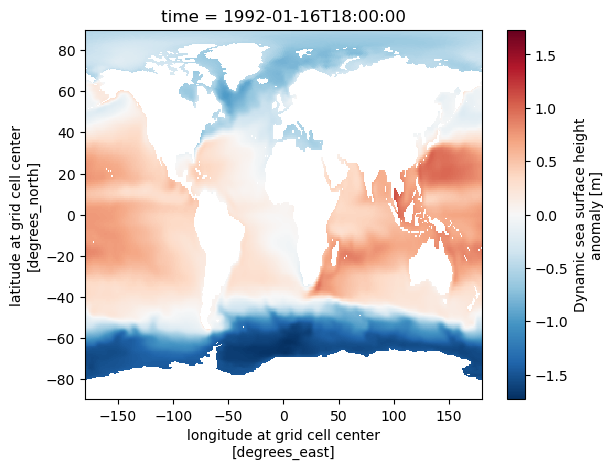

In [111]:
xx.SSH[0].plot()